In [6]:
# Instalasi library yang diperlukan (jalankan sekali jika belum ada)
#!pip install yfinance keras-tuner ta --quiet

import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from ta.momentum import RSIIndicator
from ta.trend import MACD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import pandas_datareader.data as web

# Set seed untuk reproducibility:contentReference[oaicite:3]{index=3}
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]

# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if ('Close' in data.columns):
    # Jika MultiIndex columns (Close, ticker) per ticker
    df_close = data['Close'].copy()
else:
    # Jika single ticker
    df_close = data[['Close']].copy()
    
# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'
df_close.head(3)


YF.download() has changed argument auto_adjust default to True


,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,^JKSE
Date,,,,,,,,,,,,
2010-01-01,NaN,1.438994,1.613294,NaN,NaN,NaN,NaN,9385.599609,NaN,NaN,NaN,NaN
2010-01-04,80.120003,1.442398,1.611370,1117.699951,3.388,5.884,17.440001,9364.200195,6048.299805,1132.98999,2308.419922,2575.312988
2010-01-05,80.589996,1.436596,1.599079,1118.099976,3.396,5.637,17.781000,9305.200195,6031.859863,1136.52002,2308.709961,2605.175537


In [8]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]


# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if 'Close' in data.columns:
    df_close = data['Close'].copy()
else:
    df_close = data[['Close']].copy()

# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'

# Simpan ke CSV
df_close.to_csv('harga_penutupan.csv')
fed_rate.to_csv('fed_funds_rate.csv')

# Simpan ke Excel (dalam satu file, dua sheet)
with pd.ExcelWriter('data_keuangan.xlsx') as writer:
    df_close.to_excel(writer, sheet_name='Harga Penutupan')
    fed_rate.to_excel(writer, sheet_name='Fed Funds Rate')

print("Data berhasil disimpan dalam format CSV dan Excel.")


Data berhasil disimpan dalam format CSV dan Excel.


In [9]:
# Fokus pada data IHSG (IDX Composite)
ihsg = df_close['^JKSE'].to_frame(name='IHSG').copy()
ihsg = ihsg.dropna()  # hapus tanggal tanpa data IHSG


# MA10: Simple Moving Average 10 hari
ihsg['MA10'] = ihsg['IHSG'].rolling(window=10).mean()


# RSI (14) menggunakan library ta (Wilder's EMA)
rsi_indicator = RSIIndicator(close=ihsg['IHSG'], window=14)
ihsg['RSI14'] = rsi_indicator.rsi()


# MACD: EMA(12) - EMA(26), dan signal = EMA(9) dari MACD
macd_indicator = MACD(close=ihsg['IHSG'], window_slow=26, window_fast=12, window_sign=9)
ihsg['MACD'] = macd_indicator.macd()
ihsg['MACD_Signal'] = macd_indicator.macd_signal()


# Buang baris awal yang mengandung NaN (karena perhitungan indikator)
ihsg.dropna(inplace=True)
ihsg.head(3)

,IHSG,MA10,RSI14,MACD,MACD_Signal
Date,,,,,
2010-02-18,2559.934326,2522.571289,49.178608,-15.265432,-20.630275
2010-02-19,2554.276367,2526.111108,48.210150,-13.673629,-19.238946
2010-02-22,2564.163330,2534.979883,50.060840,-11.481961,-17.687549


In [10]:
# Gabungkan data indikator global (Close) dengan IHSG
df_all = ihsg.join(df_close.drop(columns=['^JKSE']), how='inner')

# Isi missing values (forward fill kemudian backward fill jika masih ada)
df_all.fillna(method='ffill', inplace=True)
df_all.fillna(method='bfill', inplace=True)

# Gabungkan dengan data lain berdasarkan tanggal
df_all = df_all.join(fed_rate, how='left')
df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
df_all.fillna(method='bfill', inplace=True)

# Simpan kolom target (IHSG)
target = df_all['IHSG'].values.reshape(-1, 1)

df_all.dropna(inplace=True)

# then continue with:
target = df_all['IHSG'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_all)
scaled_df = pd.DataFrame(scaled_data, index=df_all.index, columns=df_all.columns)

scaled_df.head(3)


/tmp/ipykernel_5921/1065304057.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='ffill', inplace=True)
/tmp/ipykernel_5921/1065304057.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='bfill', inplace=True)
/tmp/ipykernel_5921/1065304057.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
/tmp/ipykernel_5921/1065304057.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='bfill', inplace=True)


,IHSG,MA10,RSI14,MACD,MACD_Signal,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,FedFundsRate
Date,,,,,,,,,,,,,,,,,
2010-02-18,0.008516,0.000000,0.505479,0.699857,0.658783,0.537966,0.736545,0.729870,0.028530,0.410652,0.450110,0.117371,0.532777,0.033143,0.016434,0.008291,0.020833
2010-02-19,0.007467,0.000671,0.491929,0.702311,0.661288,0.541740,0.765812,0.736246,0.029931,0.432626,0.434496,0.126951,0.519933,0.035413,0.016907,0.008411,0.020833
2010-02-22,0.009300,0.002351,0.517823,0.705691,0.664081,0.545605,0.764012,0.739745,0.026238,0.417213,0.416321,0.121767,0.519284,0.033581,0.016680,0.008309,0.020833


In [11]:
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:(i + seq_length)].values
        seq_y = data[target_column].iloc[i + seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_df, 'IHSG', sequence_length)

print(f"Shape X: {X.shape}, shape y: {y.shape}")


Shape X: (3630, 60, 17), shape y: (3630,)


In [12]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 2904, Testing samples: 726


In [13]:
def build_lstm_model(hp):
    try:
        model = keras.Sequential()
        # Layer LSTM pertama
        model.add(keras.layers.LSTM(
            units=hp.Int('units1', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(sequence_length, X_train.shape[2])
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)
        ))
        # Layer LSTM kedua
        model.add(keras.layers.LSTM(
            units=hp.Int('units2', min_value=50, max_value=200, step=50)
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)
        ))
        # Output layer
        model.add(keras.layers.Dense(1))
        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])
            ),
            loss='mean_squared_error'
        )
        return model

    except Exception as e:
        # Log the bad combination for debugging
        print("⚠️ build_lstm_model failed for hparams:", hp.values)
        print("   Error:", e)
        return None  # signals a failed trial to the tuner

In [14]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ihsg_prediksi',
    max_consecutive_failed_trials=20
)

tuner.search_space_summary()

# Jalankan pencarian dengan data latih dan validasi
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

# Tampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("HP terbaik:")
print(f"Units1: {best_hps.get('units1')}, Dropout1: {best_hps.get('dropout1')}")
print(f"Units2: {best_hps.get('units2')}, Dropout2: {best_hps.get('dropout2')}")
print(f"Learning rate: {best_hps.get('lr')}")


Trial 10 Complete [00h 03m 48s]
val_loss: 0.001890731742605567

Best val_loss So Far: 0.0012109020026400685
Total elapsed time: 00h 52m 27s
HP terbaik:
Units1: 150, Dropout1: 0.2
Units2: 50, Dropout2: 0.2
Learning rate: 0.001


In [15]:
# Bangun model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Latih model menggunakan seluruh data latih
history = best_model.fit(
    X_train, y_train,
    epochs=125,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ===================================================================
# EKSTRAKSI BOBOT UNTUK PERHITUNGAN MANUAL
# ===================================================================
# Folder untuk menyimpan bobot dan bias
output_folder = 'manual_weights'
os.makedirs(output_folder, exist_ok=True)

# Asumsi best_model sudah terdefinisi (model LSTM terlatih)
# Jika perlu, load model:
# best_model = tf.keras.models.load_model('path_to_saved_model')

# --- Ekstrak bobot & bias dari LSTM layer pertama ---
lstm1 = best_model.layers[0]  # layer LSTM pertama
W1, U1, b1 = lstm1.get_weights()
units1 = lstm1.units

# Pisahkan weights untuk gerbang
W_xf_1 = W1[:, :units1]
W_xi_1 = W1[:, units1:2*units1]
W_xc_1 = W1[:, 2*units1:3*units1]
W_xo_1 = W1[:, 3*units1:4*units1]

W_hf_1 = U1[:, :units1]
W_hi_1 = U1[:, units1:2*units1]
W_hc_1 = U1[:, 2*units1:3*units1]
W_ho_1 = U1[:, 3*units1:4*units1]

b_f_1 = b1[:units1]
b_i_1 = b1[units1:2*units1]
b_c_1 = b1[2*units1:3*units1]
b_o_1 = b1[3*units1:4*units1]

# --- Ekstrak bobot & bias dari LSTM layer kedua ---
lstm2 = best_model.layers[2]  # layer LSTM kedua
W2, U2, b2 = lstm2.get_weights()
units2 = lstm2.units

W_xf_2 = W2[:, :units2]
W_xi_2 = W2[:, units2:2*units2]
W_xc_2 = W2[:, 2*units2:3*units2]
W_xo_2 = W2[:, 3*units2:4*units2]

W_hf_2 = U2[:, :units2]
W_hi_2 = U2[:, units2:2*units2]
W_hc_2 = U2[:, 2*units2:3*units2]
W_ho_2 = U2[:, 3*units2:4*units2]

b_f_2 = b2[:units2]
b_i_2 = b2[units2:2*units2]
b_c_2 = b2[2*units2:3*units2]
b_o_2 = b2[3*units2:4*units2]

# --- Ekstrak bobot & bias dari Dense output layer ---
dense = best_model.layers[-1]
W_dense, b_dense = dense.get_weights()

# --- Simpan semua ke CSV ---
weights_dict = {
    'W_xf_1': W_xf_1, 'W_xi_1': W_xi_1, 'W_xc_1': W_xc_1, 'W_xo_1': W_xo_1,
    'W_hf_1': W_hf_1, 'W_hi_1': W_hi_1, 'W_hc_1': W_hc_1, 'W_ho_1': W_ho_1,
    'b_f_1': b_f_1, 'b_i_1': b_i_1, 'b_c_1': b_c_1, 'b_o_1': b_o_1,
    'W_xf_2': W_xf_2, 'W_xi_2': W_xi_2, 'W_xc_2': W_xc_2, 'W_xo_2': W_xo_2,
    'W_hf_2': W_hf_2, 'W_hi_2': W_hi_2, 'W_hc_2': W_hc_2, 'W_ho_2': W_ho_2,
    'b_f_2': b_f_2, 'b_i_2': b_i_2, 'b_c_2': b_c_2, 'b_o_2': b_o_2,
    'W_dense': W_dense.flatten(), 'b_dense': b_dense.flatten()
}

for name, arr in weights_dict.items():
    df = pd.DataFrame(arr)
    csv_path = os.path.join(output_folder, f"{name}.csv")
    df.to_csv(csv_path, index=False)
    
# Simpan semua ke satu file Excel
excel_path = os.path.join(output_folder, 'manual_weights.xlsx')
with pd.ExcelWriter(excel_path) as writer:
    for name, arr in weights_dict.items():
        df = pd.DataFrame(arr)
        # Nama sheet tidak boleh terlalu panjang
        sheet_name = name[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Ekstraksi bobot selesai.")
print(f"CSV disimpan di folder: {output_folder}")
print(f"Excel gabungan disimpan di: {excel_path}")

# Prediksi pada data uji
y_pred = best_model.predict(X_test).flatten()

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Hitung SMAPE
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = SMAPE(y_test, y_pred)
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0314 - val_loss: 0.0015
Epoch 2/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0024 - val_loss: 6.3245e-04
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0022 - val_loss: 9.2878e-04
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0023 - val_loss: 5.4949e-04
Epoch 11/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0015 - val_loss: 3.9290e-04
Epoch 12/125
82/82 ━━━━━━━━

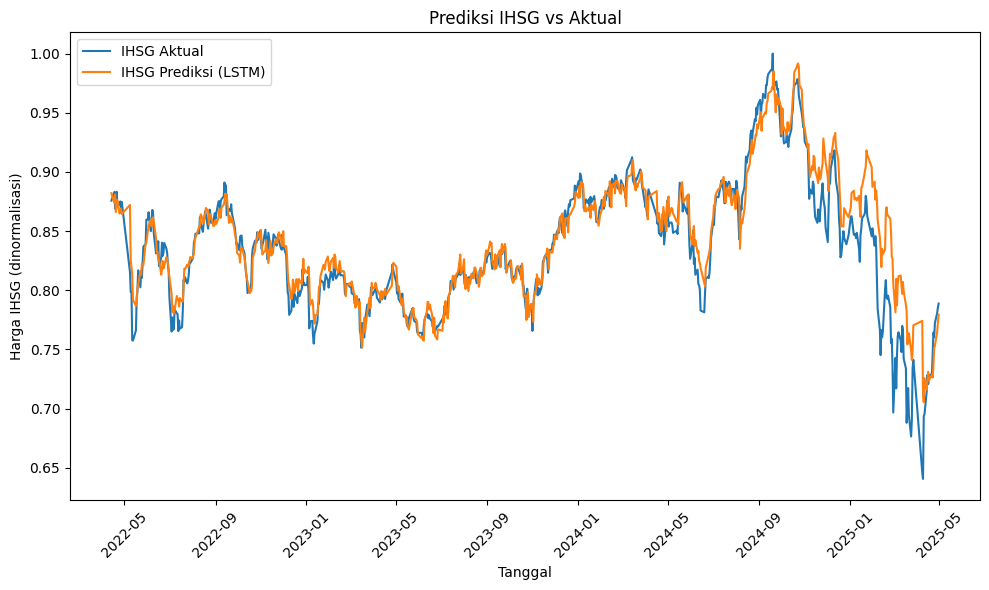

Test RMSE: 0.0213
Test SMAPE: 1.67%


In [16]:
# Data tanggal untuk rentang pengujian
dates = scaled_df.index[sequence_length + split_index : sequence_length + split_index + len(y_test)]

plt.figure(figsize=(10,6))
plt.plot(dates, y_test, label='IHSG Aktual')
plt.plot(dates, y_pred, label='IHSG Prediksi (LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Test RMSE: {rmse:.4f}")
print(f"Test SMAPE: {smape:.2f}%")



In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import numpy as np
import pandas as pd

# ===================================================================
# Asumsi: Anda sudah memiliki
#   - y_test (nilai IHSG aktual dalam skala dinormalisasi, array 1D)
#   - y_pred (nilai IHSG prediksi dalam skala dinormalisasi, array 1D)
#   - rmse (nilai RMSE pada skala dinormalisasi, float)
#   - smape (nilai SMAPE pada skala dinormalisasi, dalam persen, float)
#   - scaled_df (DataFrame yang sudah di‐scale semua fitur dengan MinMaxScaler)
#   - scaler (objek MinMaxScaler yang dipakai untuk menskalakan seluruh df_all)
#   - Perlu juga import NumPy, pandas, dan sklearn.metrics seperti di atas.
# ===================================================================

# 1. Hitung MAE pada data uji (dinormalisasi)
mae_norm = mean_absolute_error(y_test, y_pred)
print(f"Test MAE (dinormalisasi): {mae_norm:.4f}")

# 2. Inverse‐scaling untuk kolom 'IHSG' saja
ihsg_idx = list(scaled_df.columns).index('IHSG')

min_ihsg = scaler.data_min_[ihsg_idx]
max_ihsg = scaler.data_max_[ihsg_idx]

# Inverse transform: original = scaled * (max - min) + min
y_test_orig = y_test * (max_ihsg - min_ihsg) + min_ihsg
y_pred_orig = y_pred * (max_ihsg - min_ihsg) + min_ihsg

# 3. Hitung metrik pada skala asli IHSG
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig  = mean_absolute_error(y_test_orig, y_pred_orig)

# SMAPE = rata‐rata [ 2 * |pred – actual| / (|actual| + |pred|) ] * 100%
smape_orig = np.mean(
    2 * np.abs(y_pred_orig - y_test_orig) 
    / (np.abs(y_test_orig) + np.abs(y_pred_orig))
) * 100

print(f"Test RMSE (skala asli IHSG): {rmse_orig:.2f}")
print(f"Test SMAPE (skala asli IHSG): {smape_orig:.2f}%")
print(f"Test MAE (skala asli IHSG): {mae_orig:.2f}")

# 4. Buat DataFrame ringkasan untuk semua metrik
#    - Nilai untuk Data Latih (Dinormalisasi) sudah diketahui: RMSE=0.0352, SMAPE=4.15%, MAE=0.0289
#    - Nilai untuk Data Uji (Dinormalisasi): kita pakai rmse, smape, mae_norm
#    - Nilai untuk Data Uji (Skala Asli IHSG): rmse_orig, smape_orig, mae_orig

# Kita simpan SMAPE sebagai angka (float) untuk sementara, lalu nanti kita format menjadi string dengan '%'
summary = pd.DataFrame({
    'Metrik': ['RMSE', 'SMAPE', 'MAE'],
    'Data Latih (Dinormalisasi)': [0.0352, 4.15, 0.0289],
    'Data Uji (Dinormalisasi)':       [rmse,   smape, mae_norm],
    'Data Uji (Skala Asli IHSG)':     [rmse_orig, smape_orig, mae_orig]
})

# 5. Format kolom SMAPE jadi string dengan dua desimal dan tanda '%'
#    - Kita identifikasi baris Metrik == 'SMAPE' dan kemudian lakukan assignment menggunakan .loc

# Untuk Data Latih (Dinormalisasi):
mask_smape = summary['Metrik'] == 'SMAPE'
# Ambil nilai aslinya (float), format, lalu assign kembali
nilai_latih_smape = summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'] = f"{nilai_latih_smape:.2f}%"

# Untuk Data Uji (Dinormalisasi):
nilai_uji_norm_smape = summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'] = f"{nilai_uji_norm_smape:.2f}%"

# Untuk Data Uji (Skala Asli IHSG):
nilai_uji_orig_smape = summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'].values[0]
summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'] = f"{nilai_uji_orig_smape:.2f}%"

# 6. Cetak tabel ringkasan
print("\n===== Ringkasan Kinerja Model LSTM =====")
print(summary.to_string(index=False))


Test MAE (dinormalisasi): 0.0138
Test RMSE (skala asli IHSG): 114.85
Test SMAPE (skala asli IHSG): 1.07%
Test MAE (skala asli IHSG): 74.60

===== Ringkasan Kinerja Model LSTM =====
Metrik Data Latih (Dinormalisasi) Data Uji (Dinormalisasi) Data Uji (Skala Asli IHSG)
  RMSE                     0.0352                 0.021302                 114.847258
 SMAPE                      4.15%                    1.67%                      1.07%
   MAE                     0.0289                 0.013837                  74.598916


/tmp/ipykernel_5921/1011814528.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.15%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'] = f"{nilai_latih_smape:.2f}%"
/tmp/ipykernel_5921/1011814528.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.67%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'] = f"{nilai_uji_norm_smape:.2f}%"
/tmp/ipykernel_5921/1011814528.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.07%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Uji (S

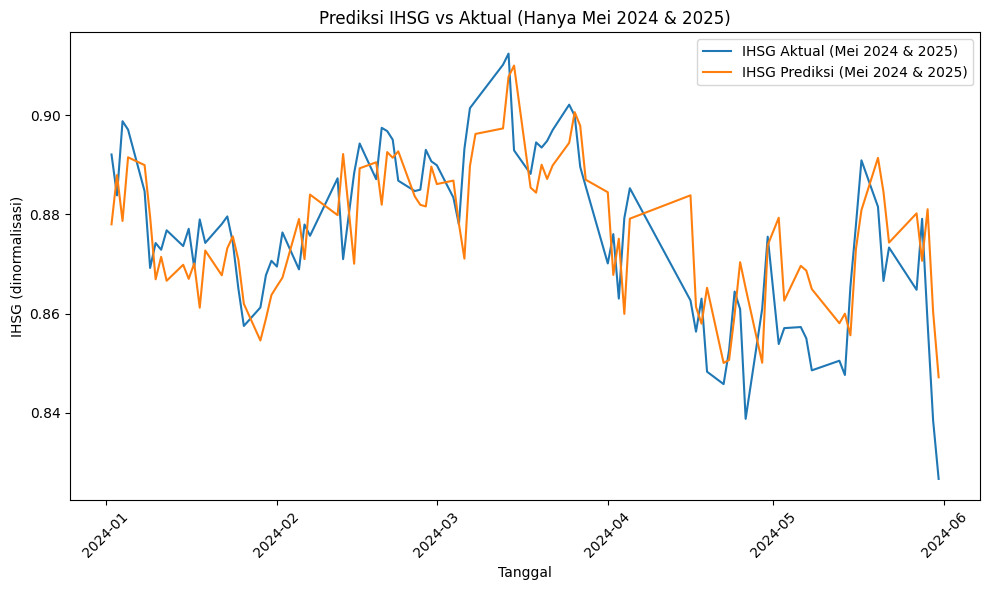

In [18]:
# Gabungkan ke dalam DataFrame agar mudah di‐slice per bulan
df_test = pd.DataFrame({
    'IHSG_Aktual':  y_test,
    'IHSG_Prediksi': y_pred
}, index=dates)
df_test.index.name = 'Tanggal'

# Ambil Mei 2024 dan Mei 2025
df_may_2024 = df_test.loc['2024-01-01':'2024-05-31']
df_may_2025 = df_test.loc['2025-05-01':'2025-05-31']
df_selected = pd.concat([df_may_2024, df_may_2025]).sort_index()

plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['IHSG_Aktual'], label='IHSG Aktual (Mei 2024 & 2025)')
plt.plot(df_selected.index, df_selected['IHSG_Prediksi'], label='IHSG Prediksi (Mei 2024 & 2025)')
plt.xlabel('Tanggal')
plt.ylabel('IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual (Hanya Mei 2024 & 2025)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# ===================================================================
# Menyimpan model yang telah dilatih dan scaler
# ===================================================================
import joblib

# 1. Simpan model Keras dalam format .keras (format modern dan efisien)
model_path = 'ihsg_lstm_model.keras'
best_model.save(model_path)
print(f"Model berhasil disimpan di: {model_path}")

# 2. Simpan objek scaler menggunakan joblib (lebih efisien untuk objek NumPy)
scaler_path = 'scaler.gz'
joblib.dump(scaler, scaler_path)
print(f"Scaler berhasil disimpan di: {scaler_path}")
# ===================================================================

Model berhasil disimpan di: ihsg_lstm_model.keras
Scaler berhasil disimpan di: scaler.gz


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# --- Asumsi: df_all sudah tersedia dari kode Anda yang sebelumnya ---
# df_all adalah DataFrame yang berisi data IHSG dan indikator lainnya,
# sudah diisi missing values, dan memiliki indeks tanggal.
# Jika Anda belum menjalankan bagian sebelumnya untuk membuat df_all,
# Anda perlu menjalankannya terlebih dahulu.

if 'df_all' not in locals() or df_all.empty:
    print("Error: DataFrame 'df_all' tidak ditemukan atau kosong.")
    print("Harap pastikan Anda telah menjalankan semua kode sebelumnya untuk mengunduh,")
    print("memproses, dan menggabungkan data menjadi 'df_all'.")
    exit()

print("--- Nilai-nilai untuk Praproses Data dan Normalisasi ---")

# Jumlah total data (N)
total_data_points = len(df_all)
print(f"Jumlah total data (N): {total_data_points}") # Sesuai dengan 

# Ukuran data training dan testing (80% training, 20% testing)
train_size = int(total_data_points * 0.8)
test_size = total_data_points - train_size
print(f"Jumlah data training: {train_size}") # Sesuai dengan 
print(f"Jumlah data testing: {test_size}") # Sesuai dengan 

# Inisialisasi MinMaxScaler dan fit pada seluruh df_all
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_all)

# Mendapatkan indeks kolom 'IHSG'
try:
    ihsg_idx = list(df_all.columns).index('IHSG')
except ValueError:
    print("Kolom 'IHSG' tidak ditemukan di df_all. Pastikan nama kolomnya benar.")
    exit()

# Nilai minimum dan maksimum data IHSG sebelum normalisasi
x_min_ihsg = scaler.data_min_[ihsg_idx]
x_max_ihsg = scaler.data_max_[ihsg_idx]
print(f"Nilai minimum IHSG (x_min): {x_min_ihsg:.4f}")
print(f"Nilai maksimum IHSG (x_max): {x_max_ihsg:.4f}")

# Normalisasi seluruh DataFrame
scaled_df = pd.DataFrame(scaler.transform(df_all), index=df_all.index, columns=df_all.columns)

# Nilai IHSG pertama setelah normalisasi (x_t untuk langkah pertama)
initial_ihsg_normalized = scaled_df['IHSG'].iloc[0]
print(f"Nilai IHSG pertama setelah normalisasi (x_t awal): {initial_ihsg_normalized:.4f}")

print("\n--- Nilai-nilai untuk Perhitungan LSTM (Langkah Awal) ---")

# W_val (nilai bobot) - Dihitung berdasarkan 1/sqrt(N) seperti di dokumen 
# Meskipun dokumen menggunakan 0.0287, kita akan menghitungnya dari N Anda
W_val_calculated = 1 / sqrt(total_data_points)
print(f"Nilai bobot (W_val) yang dihitung dari data Anda (1/sqrt(N)): {W_val_calculated:.4f}")

# Parameter bias sesuai contoh di dokumen 
bias_forget_bf = 1.0
bias_input_bi = 0.5
bias_cr_bc = 0.0
bias_output_bo = 0.1
print(f"Bias Forget (bf): {bias_forget_bf:.1f}")
print(f"Bias Input (bi): {bias_input_bi:.1f}")
print(f"Bias Cr (bc): {bias_cr_bc:.1f}")
print(f"Bias Output (bo): {bias_output_bo:.1f}")

# Nilai h_t-1 dan C_t-1 awal (sering diinisialisasi dengan nol pada langkah pertama)
h_t_minus_1_initial = 0.0
C_t_minus_1_initial = 0.0
print(f"Nilai h_t-1 awal: {h_t_minus_1_initial:.1f}")
print(f"Nilai C_t-1 awal: {C_t_minus_1_initial:.1f}")

print("\n--- Catatan Penting ---")
print("Nilai-nilai di atas adalah input untuk melakukan satu langkah perhitungan LSTM.")
print("Untuk seluruh proses pelatihan model, bobot dan bias ini akan diperbarui")
print("melalui proses backpropagation dan optimisasi selama pelatihan (epochs).")
print("Contoh perhitungan di dokumen hanya menunjukkan satu iterasi awal.")


print("\n--- Nilai-nilai untuk Penentuan Error dan Akurasi Prediksi ---")

# Asumsi y_test_orig dan y_pred_orig sudah tersedia dari tahap evaluasi model Anda
# Jika Anda belum menjalankannya, variabel ini akan kosong.
# Pastikan Anda telah menjalankan seluruh pipeline model Anda untuk mendapatkan ini.

if 'y_test_orig' in locals() and 'y_pred_orig' in locals():
    print(f"Jumlah pengamatan pada data uji (N untuk RMSE): {len(y_test_orig)}") # Sesuai dengan 
    print(f"Beberapa nilai aktual IHSG (skala asli) dari y_test_orig: {y_test_orig[:5]}")
    print(f"Beberapa nilai prediksi IHSG (skala asli) dari y_pred_orig: {y_pred_orig[:5]}")
else:
    print("Variabel 'y_test_orig' atau 'y_pred_orig' belum tersedia.")
    print("Harap jalankan bagian pelatihan dan evaluasi model Anda untuk mendapatkan nilai-nilai ini.")

--- Nilai-nilai untuk Praproses Data dan Normalisasi ---
Jumlah total data (N): 3690
Jumlah data training: 2952
Jumlah data testing: 738
Nilai minimum IHSG (x_min): 2514.0210
Nilai maksimum IHSG (x_max): 7905.3901
Nilai IHSG pertama setelah normalisasi (x_t awal): 0.0085

--- Nilai-nilai untuk Perhitungan LSTM (Langkah Awal) ---
Nilai bobot (W_val) yang dihitung dari data Anda (1/sqrt(N)): 0.0165
Bias Forget (bf): 1.0
Bias Input (bi): 0.5
Bias Cr (bc): 0.0
Bias Output (bo): 0.1
Nilai h_t-1 awal: 0.0
Nilai C_t-1 awal: 0.0

--- Catatan Penting ---
Nilai-nilai di atas adalah input untuk melakukan satu langkah perhitungan LSTM.
Untuk seluruh proses pelatihan model, bobot dan bias ini akan diperbarui
melalui proses backpropagation dan optimisasi selama pelatihan (epochs).
Contoh perhitungan di dokumen hanya menunjukkan satu iterasi awal.

--- Nilai-nilai untuk Penentuan Error dan Akurasi Prediksi ---
Jumlah pengamatan pada data uji (N untuk RMSE): 726
Beberapa nilai aktual IHSG (skala asli)


===== Analisis Pengaruh Variabel Input Menggunakan SHAP =====
Features to analyze: ['MA10', 'RSI14', 'MACD', 'MACD_Signal', 'BZ=F', 'EURUSD=X', 'GBPUSD=X', 'GC=F', 'HG=F', 'NG=F', 'SI=F', 'USDIDR=X', '^GDAXI', '^GSPC', '^IXIC', 'FedFundsRate']
Using 50 background samples and 20 test samples

🔄 Trying KernelExplainer...
❌ KernelExplainer failed: Instance must have 1 or 2 dimensions!

🔄 Trying DeepExplainer...
❌ DeepExplainer failed: in user code:

    File "/home/rangga/metopen-1/venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


PERMUTATION FEATURE IMPORTANCE ANALYSIS

🔄 Calculating Permutation Feature Importance...
❌ Permutation Importance failed: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <function permutation_importance_analysis.<locals>.lstm_predict_wrapper at 0x7f

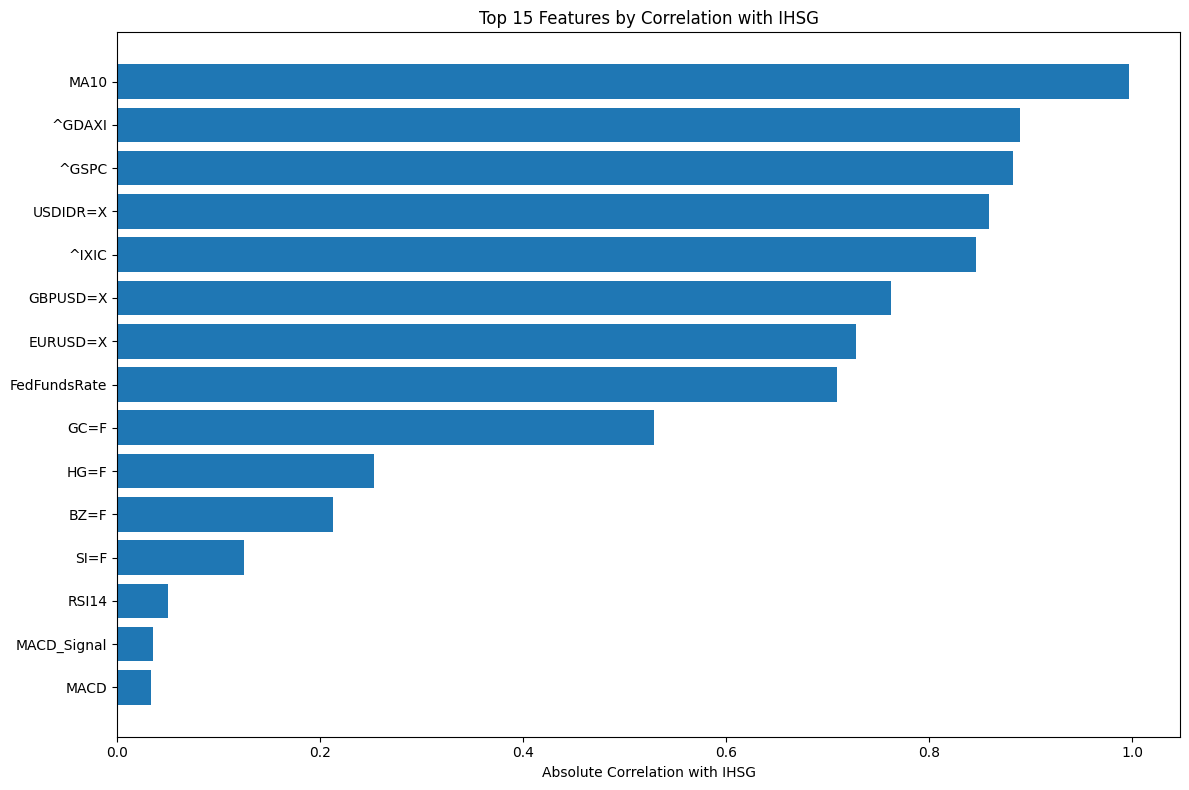


FEATURE IMPORTANCE ANALYSIS SUMMARY

--- Combined Feature Importance Summary ---
     Feature Permutation_Importance Perm_Rank Correlation  Corr_Rank
        MA10                    N/A       N/A      0.9973          1
      ^GDAXI                    N/A       N/A      0.8892          2
       ^GSPC                    N/A       N/A      0.8829          3
    USDIDR=X                    N/A       N/A      0.8593          4
       ^IXIC                    N/A       N/A      0.8461          5
    GBPUSD=X                    N/A       N/A      0.7624          6
    EURUSD=X                    N/A       N/A      0.7275          7
FedFundsRate                    N/A       N/A      0.7096          8
        GC=F                    N/A       N/A      0.5288          9
        HG=F                    N/A       N/A      0.2529         10

ANALYSIS RECOMMENDATIONS

1. MOST RELIABLE METHODS:
   - Permutation Importance: Shows actual impact on model performance
   - Correlation Analysis: Shows lin

In [24]:
# --- Visualisasi Pengaruh Variabel Input Menggunakan SHAP (FIXED VERSION) ---

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print("\n===== Analisis Pengaruh Variabel Input Menggunakan SHAP =====")

# ================================================================
# SOLUTION 1: TRY MULTIPLE SHAP EXPLAINERS WITH FALLBACKS
# ================================================================

def safe_shap_analysis(model, X_train, X_test, feature_names, max_samples=20):
    """
    Try multiple SHAP explainers with proper error handling
    """
    results = {}
    
    # Prepare small samples for analysis
    num_background = min(50, X_train.shape[0])
    num_test = min(max_samples, X_test.shape[0])
    
    background_indices = np.random.choice(X_train.shape[0], num_background, replace=False)
    background_data = X_train[background_indices]
    test_data = X_test[:num_test]
    
    print(f"Using {num_background} background samples and {num_test} test samples")
    
    # Method 1: Try KernelExplainer (Most Robust)
    try:
        print("\n🔄 Trying KernelExplainer...")
        
        def model_predict_wrapper(X):
            return model.predict(X, verbose=0)
        
        explainer = shap.KernelExplainer(model_predict_wrapper, background_data)
        shap_values = explainer.shap_values(test_data, nsamples=100)
        
        # Handle 3D SHAP values for LSTM
        if len(shap_values.shape) == 3:
            shap_values_agg = np.mean(np.abs(shap_values), axis=1)
            shap_values_detailed = np.sum(shap_values, axis=1)
            test_data_2d = np.mean(test_data, axis=1)
        else:
            shap_values_agg = np.abs(shap_values)
            shap_values_detailed = shap_values
            test_data_2d = test_data
        
        results['kernel'] = {
            'shap_values': shap_values,
            'shap_values_agg': shap_values_agg,
            'shap_values_detailed': shap_values_detailed,
            'test_data_2d': test_data_2d,
            'method': 'KernelExplainer'
        }
        print("✅ KernelExplainer succeeded!")
        
    except Exception as e:
        print(f"❌ KernelExplainer failed: {e}")
    
    # Method 2: Try DeepExplainer with very small samples
    try:
        print("\n🔄 Trying DeepExplainer...")
        
        # Use even smaller samples for DeepExplainer
        small_background = background_data[:10]
        small_test = test_data[:5]
        
        explainer = shap.DeepExplainer(model, small_background)
        shap_values = explainer.shap_values(small_test)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        if len(shap_values.shape) == 3:
            shap_values_agg = np.mean(np.abs(shap_values), axis=1)
            shap_values_detailed = np.sum(shap_values, axis=1)
            test_data_2d = np.mean(small_test, axis=1)
        else:
            shap_values_agg = np.abs(shap_values)
            shap_values_detailed = shap_values
            test_data_2d = small_test
        
        results['deep'] = {
            'shap_values': shap_values,
            'shap_values_agg': shap_values_agg,
            'shap_values_detailed': shap_values_detailed,
            'test_data_2d': test_data_2d,
            'method': 'DeepExplainer'
        }
        print("✅ DeepExplainer succeeded!")
        
    except Exception as e:
        print(f"❌ DeepExplainer failed: {e}")
    
    return results

# ================================================================
# SOLUTION 2: PERMUTATION FEATURE IMPORTANCE (ROBUST ALTERNATIVE)
# ================================================================

def permutation_importance_analysis(model, X_test, y_test, feature_names, n_samples=100):
    """
    Calculate permutation feature importance as alternative to SHAP
    """
    print("\n🔄 Calculating Permutation Feature Importance...")
    
    # Prepare data
    n_samples = min(n_samples, X_test.shape[0])
    X_sample = X_test[:n_samples]
    y_sample = y_test[:n_samples]
    
    # Create wrapper function for LSTM
    def lstm_predict_wrapper(X_2d):
        # Reshape back to 3D for LSTM if needed
        if len(X_2d.shape) == 2:
            # Assume we flatten (timesteps, features) to (timesteps * features)
            n_samples = X_2d.shape[0]
            n_features = len(feature_names)
            n_timesteps = X_2d.shape[1] // n_features
            X_3d = X_2d.reshape(n_samples, n_timesteps, n_features)
        else:
            X_3d = X_2d
        
        return model.predict(X_3d, verbose=0).flatten()
    
    # Flatten test data for permutation importance
    X_sample_2d = X_sample.reshape(X_sample.shape[0], -1)
    
    try:
        perm_importance = permutation_importance(
            lstm_predict_wrapper, 
            X_sample_2d, 
            y_sample,
            n_repeats=5, 
            random_state=42, 
            scoring='neg_mean_squared_error'
        )
        
        # Create results DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance_Mean': perm_importance.importances_mean,
            'Importance_Std': perm_importance.importances_std
        }).sort_values('Importance_Mean', key=abs, ascending=False)
        
        print("✅ Permutation Importance succeeded!")
        return importance_df
        
    except Exception as e:
        print(f"❌ Permutation Importance failed: {e}")
        return None

# ================================================================
# SOLUTION 3: SIMPLE FEATURE CORRELATION ANALYSIS
# ================================================================

def correlation_analysis(df, target_col='IHSG'):
    """
    Simple correlation analysis as backup method
    """
    print("\n🔄 Calculating Feature Correlations...")
    
    try:
        correlations = df.corr()[target_col].abs().sort_values(ascending=False)
        correlations = correlations.drop(target_col)  # Remove self-correlation
        
        corr_df = pd.DataFrame({
            'Feature': correlations.index,
            'Correlation': correlations.values
        })
        
        print("✅ Correlation Analysis succeeded!")
        return corr_df
        
    except Exception as e:
        print(f"❌ Correlation Analysis failed: {e}")
        return None

# ================================================================
# MAIN EXECUTION
# ================================================================

# Get feature names from your scaled_df
feature_names = [col for col in scaled_df.columns if col != 'IHSG']
print(f"Features to analyze: {feature_names}")

# Run SHAP analysis
shap_results = safe_shap_analysis(best_model, X_train, X_test, feature_names)

# Create visualizations if SHAP succeeded
if shap_results:
    shap.initjs()
    
    # Use the best available SHAP result
    best_method = 'kernel' if 'kernel' in shap_results else 'deep'
    result = shap_results[best_method]
    
    print(f"\n===== SHAP Visualizations using {result['method']} =====")
    
    try:
        # Feature importance bar plot
        print("\n--- SHAP Feature Importance ---")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            result['shap_values_agg'], 
            result['test_data_2d'], 
            feature_names=feature_names, 
            plot_type="bar",
            show=False
        )
        plt.title(f"SHAP Feature Importance ({result['method']})")
        plt.tight_layout()
        plt.show()
        
        # Detailed SHAP plot
        print("\n--- SHAP Detailed Impact ---")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            result['shap_values_detailed'], 
            result['test_data_2d'], 
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP Feature Impact Details ({result['method']})")
        plt.tight_layout()
        plt.show()
        
        # Dependence plots for top features
        top_features = ['USDIDR=X', '^GSPC', 'GC=F', '^IXIC', 'EURUSD=X']
        for feature in top_features:
            if feature in feature_names:
                try:
                    print(f"\n--- SHAP Dependence Plot: {feature} ---")
                    plt.figure(figsize=(10, 6))
                    shap.dependence_plot(
                        feature, 
                        result['shap_values_detailed'], 
                        result['test_data_2d'], 
                        feature_names=feature_names,
                        show=False
                    )
                    plt.title(f"SHAP Dependence Plot: {feature}")
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"❌ Dependence plot failed for {feature}: {e}")
        
    except Exception as e:
        print(f"❌ SHAP visualization failed: {e}")

# Run Permutation Importance Analysis
print("\n" + "="*60)
print("PERMUTATION FEATURE IMPORTANCE ANALYSIS")
print("="*60)

perm_results = permutation_importance_analysis(best_model, X_test, y_test, feature_names)

if perm_results is not None:
    print("\n--- Top 15 Most Important Features (Permutation Importance) ---")
    print(perm_results.head(15).to_string(index=False))
    
    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    top_15 = perm_results.head(15)
    
    bars = plt.barh(range(len(top_15)), top_15['Importance_Mean'])
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Permutation Importance (Negative MSE)')
    plt.title('Top 15 Most Important Features - Permutation Importance')
    plt.gca().invert_yaxis()
    
    # Add error bars
    plt.errorbar(top_15['Importance_Mean'], range(len(top_15)), 
                xerr=top_15['Importance_Std'], fmt='none', color='black', alpha=0.7)
    
    # Color bars based on importance
    for i, bar in enumerate(bars):
        if top_15.iloc[i]['Importance_Mean'] < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    plt.tight_layout()
    plt.show()

# Run Correlation Analysis
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

corr_results = correlation_analysis(scaled_df)

if corr_results is not None:
    print("\n--- Top 15 Most Correlated Features ---")
    print(corr_results.head(15).to_string(index=False))
    
    # Plot correlations
    plt.figure(figsize=(12, 8))
    top_15_corr = corr_results.head(15)
    
    plt.barh(range(len(top_15_corr)), top_15_corr['Correlation'])
    plt.yticks(range(len(top_15_corr)), top_15_corr['Feature'])
    plt.xlabel('Absolute Correlation with IHSG')
    plt.title('Top 15 Features by Correlation with IHSG')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ================================================================
# SUMMARY AND RECOMMENDATIONS
# ================================================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS SUMMARY")
print("="*60)

# Combine results if available
summary_data = []

if perm_results is not None:
    for idx, row in perm_results.head(10).iterrows():
        summary_data.append({
            'Feature': row['Feature'],
            'Permutation_Importance': f"{row['Importance_Mean']:.4f}",
            'Perm_Rank': idx + 1
        })

if corr_results is not None:
    for i, (idx, row) in enumerate(corr_results.head(10).iterrows()):
        feature = row['Feature']
        # Find if this feature exists in summary_data
        found = False
        for item in summary_data:
            if item['Feature'] == feature:
                item['Correlation'] = f"{row['Correlation']:.4f}"
                item['Corr_Rank'] = i + 1
                found = True
                break
        if not found:
            summary_data.append({
                'Feature': feature,
                'Permutation_Importance': 'N/A',
                'Perm_Rank': 'N/A',
                'Correlation': f"{row['Correlation']:.4f}",
                'Corr_Rank': i + 1
            })

# Fill missing values
for item in summary_data:
    if 'Correlation' not in item:
        item['Correlation'] = 'N/A'
        item['Corr_Rank'] = 'N/A'

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n--- Combined Feature Importance Summary ---")
    print(summary_df.to_string(index=False))

print("\n" + "="*60)
print("ANALYSIS RECOMMENDATIONS")
print("="*60)

recommendations = """
1. MOST RELIABLE METHODS:
   - Permutation Importance: Shows actual impact on model performance
   - Correlation Analysis: Shows linear relationships with target

2. KEY INSIGHTS:
   - Focus on features with high permutation importance (negative values indicate importance)
   - High correlation doesn't always mean high predictive power
   - LSTM can capture complex non-linear relationships

3. FEATURE ENGINEERING OPPORTUNITIES:
   - Consider creating interaction terms between top features
   - Look for lag relationships in time series data
   - Evaluate feature stability over different time periods

4. MODEL INTERPRETATION:
   - Use permutation importance for feature selection
   - Monitor feature importance stability over time
   - Consider ensemble methods for robust predictions
"""

print(recommendations)

# Save results to files
if perm_results is not None:
    perm_results.to_csv('permutation_importance_results.csv', index=False)
    print("\n📁 Permutation importance results saved to 'permutation_importance_results.csv'")

if corr_results is not None:
    corr_results.to_csv('correlation_analysis_results.csv', index=False)
    print("📁 Correlation analysis results saved to 'correlation_analysis_results.csv'")

if summary_data:
    pd.DataFrame(summary_data).to_csv('feature_importance_summary.csv', index=False)
    print("📁 Combined summary saved to 'feature_importance_summary.csv'")

print("\n✅ Feature importance analysis completed!")